<a href="https://colab.research.google.com/github/zeineb12/text_classification/blob/master/basic_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Relevant-imports" data-toc-modified-id="Relevant-imports-1">Relevant imports</a></span></li><li><span><a href="#Dataset-shape" data-toc-modified-id="Dataset-shape-2">Dataset shape</a></span><ul class="toc-item"><li><span><a href="#Drop-duplicates" data-toc-modified-id="Drop-duplicates-2.1">Drop duplicates</a></span></li></ul></li><li><span><a href="#Tweets-length" data-toc-modified-id="Tweets-length-3">Tweets length</a></span></li><li><span><a href="#Data-concatenation" data-toc-modified-id="Data-concatenation-4">Data concatenation</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-5">Data Cleaning</a></span></li><li><span><a href="#Word-cloud-TODO" data-toc-modified-id="Word-cloud-TODO-6">Word cloud TODO</a></span></li><li><span><a href="#Split-train/validation/test" data-toc-modified-id="Split-train/validation/test-7">Split train/validation/test</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-8">Baseline</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-using-CountVectorizer" data-toc-modified-id="Naive-Bayes-using-CountVectorizer-8.1">Naive Bayes using CountVectorizer</a></span></li><li><span><a href="#Naive-Bayes-using-TfidfTransformer" data-toc-modified-id="Naive-Bayes-using-TfidfTransformer-8.2">Naive Bayes using TfidfTransformer</a></span></li><li><span><a href="#Logistic-Regression-using-TfidfTransformer" data-toc-modified-id="Logistic-Regression-using-TfidfTransformer-8.3">Logistic Regression using TfidfTransformer</a></span></li></ul></li><li><span><a href="#Feature-engineering-choices-(can-later-on-test-on-NN-model)" data-toc-modified-id="Feature-engineering-choices-(can-later-on-test-on-NN-model)-9">Feature engineering choices (can later on test on NN model)</a></span><ul class="toc-item"><li><span><a href="#Stop-words-(TODO:-improve-custom-list)" data-toc-modified-id="Stop-words-(TODO:-improve-custom-list)-9.1">Stop words (TODO: improve custom list)</a></span></li><li><span><a href="#N-Grams" data-toc-modified-id="N-Grams-9.2">N Grams</a></span></li></ul></li><li><span><a href="#Test-submission" data-toc-modified-id="Test-submission-10">Test submission</a></span></li></ul></div>

## Relevant imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import validation_curve
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from utils import open_by_tweets
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from utils import create_csv_submission
SEED = 15432

/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/dict_vectorizer.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Dataset shape

In [2]:
with open('data/train_pos.txt',"r") as file:
    train_pos = file.read().split('\n')
train_pos = pd.DataFrame({'tweet' : train_pos})[:len(train_pos)-1]

with open('data/train_neg.txt',"r") as file:
    train_neg = file.read().split('\n')
train_neg = pd.DataFrame({'tweet' : train_neg})[:len(train_neg)-1]

### Drop duplicates
Let's drop duplicates from our dataset

In [3]:
train_neg.drop_duplicates(inplace=True)
train_pos.drop_duplicates(inplace=True)

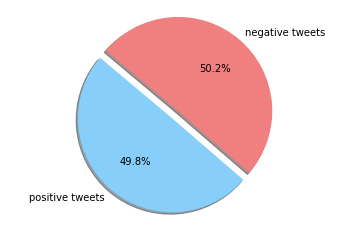

In [4]:
# Data to plot
labels = 'positive tweets', 'negative tweets'
sizes = [len(train_pos), len(train_neg)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We see that the dataset is balanced

## Tweets length
* We add a column containing the tweet length for each tweet (in number of characters)

In [5]:
train_neg['tweet_len'] = [len(t) for t in train_neg.tweet]
train_pos['tweet_len'] = [len(t) for t in train_pos.tweet]

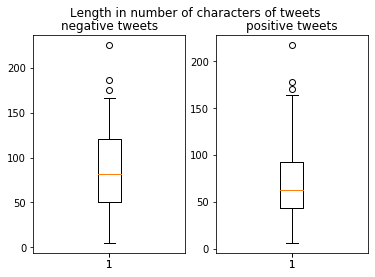

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

ax = axs[0]
ax.boxplot(train_neg.tweet_len, whis=0.7)
ax.set_title('negative tweets')

ax = axs[1]
ax.boxplot(train_pos.tweet_len, whis=1.5)
ax.set_title('positive tweets')

fig.suptitle('Length in number of characters of tweets')
plt.show()

* We see that positive tweets tend to be shorter than negative tweets (mean and std are both smaller)

* However, something that's a bit strange, some of the tweets are way more than 140 characters long. But twitter’s character limit is 140.

In [7]:
train_pos[train_pos.tweet_len > 200].head(4)

,tweet,tweet_len
19278,""" <user> have so much fun at prom <user> \ 355...",217


In [8]:
train_pos.loc[19278].tweet

'" <user> have so much fun at prom <user> \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 227 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 221 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 217 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 213 " yayyy shanny ! ! ! #dodaadirty'

Maybe these numbers used to stand for emojis and when the html text was processed they becaùe like these

In [9]:
re.sub(r'\\ [0-9]+ ','',train_pos.loc[19278].tweet)

'" <user> have so much fun at prom <user> " yayyy shanny ! ! ! #dodaadirty'

## Data concatenation

In [10]:
train_pos['label'] = 1
train_neg['label'] = 0
train_set = train_pos.append(train_neg)
train_set.head(6)

,tweet,tweet_len,label
0,<user> i dunno justin read my mention or not ....,127,1
1,"because your logic is so dumb , i won't even c...",91,1
2,""" <user> just put casper in a box ! "" looved t...",69,1
3,<user> <user> thanks sir > > don't trip lil ma...,78,1
4,visiting my brother tmr is the bestest birthda...,66,1
5,<user> yay ! ! #lifecompleted . tweet / facebo...,73,1


## Data Cleaning

In [11]:
#train_set[train_set['tweet'].str.contains('</3')]#.loc[70514].tweet

In [18]:
def replace_exclamations(x):
    """ Replaces multiple exclamation marks by the word exclamationMark """
    x = re.sub('(\! )+(?=(\!))', '', x)
    x = re.sub(r"(\!)+", ' exclamationMark ', x)
    return x


def replace_questions(x):
    """ Replaces multiple question marks by the word questionMark """
    x = re.sub('(\? )+(?=(\?))', '', x)
    x = re.sub(r"(\?)+", ' questionMark ', x)
    return x

def tokenization(text):
    text = re.split('\W+', text)
    return text

def lemmatizer(l,text):
    text = [l.lemmatize(word) for word in text]
    return text

def join_tokens(tokens):
    text = ' '.join(tokens)
    return text

def replace_points(x):
    """ Replaces multiple points by the word multiplePoints """
    x = re.sub('(\. )+(?=(\.))', '', x)
    x = re.sub(r"(\.)+", ' multistop ', x)
    return x

def translate_emojis(x):
    """ Replace emojis into meaningful words """
    x = re.sub(' [:,=]( )*[\),\],},D] ', ' happy ', x) #:) :D :} :]
    x = re.sub(' [:,=]( )*[\(,\[,{,] ', ' sad ', x) #:( :{ :[
    x = re.sub(' X( )*D ', ' funny ', x) #XD
    x = re.sub(' [:,=]( )*p ', ' silly ', x) #:p
    x = re.sub(' [:,=]( )*-( )*p ', ' silly ', x) #:-p
    x = re.sub(' \[( )*[:,=] ', ' happy ', x) #[:
    x = re.sub(' [:,=]( )*[o,0] ', ' surprise ', x) #:o :O
    x = re.sub(' [x,X]+ ', ' kiss ', x) #xXxX
    x = re.sub(' [:,=]( )*\* ', ' kiss ', x) #:*
    x = re.sub(' [:,=]( )*-( )*[D,\)] ', ' happy ', x) #:-D :-)
    x = re.sub(' [:,=]( )*/ ', ' confused ', x) #:/
    x = re.sub(' <( )*3 ', ' love ', x) #<3
    x = re.sub(' <( )*/( )*3 ', ' sad ', x) #</3
    x = re.sub(' [:,=]( )*@ ', ' mad ', x) #:@
    x = re.sub(' [:,=]( )*\'( )*\( ', ' sad ', x) #:'(
    x = re.sub(' [:,=]( )*\'( )*[\),D] ', ' happy ', x) #:') :'D
    x = re.sub('([h,j][a,e,i,o]){2,}', 'haha', x) #hahaha
    return x

def split_negation(text):
    #TODO augment this list with words
    negations_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                    "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                    "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                    "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                    "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dict.keys()) + r')\b')
    text = neg_pattern.sub(lambda x: negations_dict[x.group()], text)
    return text

In [19]:
def tweet_cleaner(tweet):
    #seperate negative words
    tweet = split_negation(tweet)
    #seperate punctuation from words
    tweet = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", tweet)
    #remove the observed pattern of numbers seen above
    tweet = re.sub(r'\\ [0-9]+ ', '', tweet)
    #replace ?,!,. by words
    tweet = replace_exclamations(tweet)
    tweet = replace_questions(tweet)
    tweet = replace_points(tweet)
    #translate emojis
    tweet = translate_emojis(tweet)
    
    #Now since we translated punctuation and emojis and negative words we can remove the rest of the 'unwanted' chars
    #remove unwanted punctuation
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    
    #remove trailing and leading whitespace
    tweet = tweet.strip() 
    #remove multiple consecutive whitespaces
    tweet = re.sub(' +', ' ',tweet)
    #lowercase tweet
    tweet = tweet.lower() 
    
    #correct spelling : deals with goooood -> good
    #b = TextBlob(tweet)
    #tweet = str(b.correct())
    
    #Lemmatization
    l = WordNetLemmatizer() 
    tweet = tokenization(tweet)
    tweet = join_tokens(lemmatizer(l,tweet))
    return tweet

In [20]:
train_set['tweet'] = train_set['tweet'].apply(tweet_cleaner)

In [21]:
train_set.to_pickle("./data/tweets.pkl")

## Word cloud TODO

In [22]:
#insert code here & save files for report
#wordcloud.to_file("img/pos_tweets.png")
#wordcloud.to_file("img/neg_tweets.png")

## Split train/validation/test

In [23]:
x = train_set.tweet
y = train_set.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=SEED)

In [24]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print( "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 126924 entries with 50.17% negative, 49.83% positive
Validation set has total 27198 entries with 50.08% negative, 49.92% positive
Test set has total 27199 entries with 50.67% negative, 49.33% positive


## Baseline

### Naive Bayes using CountVectorizer 

In [25]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
print('Overall number of different words',len(count_vect.get_feature_names()))
clf = MultinomialNB().fit(x_train_counts, y_train)
y_predicted = clf.predict(count_vect.transform(x_test))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_test, y_predicted)}')

Overall number of different words 68423
Our model's accuracy is 0.721533879922056


### Naive Bayes using TfidfTransformer

In [26]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
print('Overall number of different words',x_train_tfidf.shape[1])
clf = MultinomialNB().fit(x_train_tfidf, y_train)
y_predicted = clf.predict(tfidf_transformer.transform(count_vect.transform(x_test)))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_test, y_predicted)}')

Overall number of different words 68423
Our model's accuracy is 0.7510937902128755


### Logistic Regression using TfidfTransformer

In [27]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
print('Overall number of different words',x_train_tfidf.shape[1])
clf = LogisticRegression().fit(x_train_tfidf, y_train)
y_predicted = clf.predict(tfidf_transformer.transform(count_vect.transform(x_test)))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_test, y_predicted)}')

Overall number of different words 68423
Our model's accuracy is 0.7953968895915291


For the rest, we use Logistic regression to be our baseline

## Feature engineering choices (can later on test on NN model)
### Stop words (TODO: improve custom list)

In [28]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    """Helper function to compute accuracy for some pipeline"""
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [29]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
lr = LogisticRegression()
n_features = np.arange(10000,80000,10000)

def nfeature_accuracy_checker(vectorizer=count_vect, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    """Helper to get accuracies for different number of features"""
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', tfidf_transformer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append(nfeature_accuracy)
    return result

In [30]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_with_stop = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.08%
accuracy score: 79.73%
model is 29.65% more accurate than null accuracy
train and test time: 4.38s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.08%
accuracy score: 79.68%
model is 29.59% more accurate than null accuracy
train and test time: 4.45s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.08%
accuracy score: 79.73%
model is 29.64% more accurate than null accuracy
train and test time: 5.01s
-------------------------------------------------------------

In [31]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_without_stop = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.08%
accuracy score: 77.69%
model is 27.60% more accurate than null accuracy
train and test time: 4.12s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.08%
accuracy score: 77.83%
model is 27.74% more accurate than null accuracy
train and test time: 4.12s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.08%
accuracy score: 77.92%
model is 27.83% more accurate than null accuracy
train and test time: 4.65s
----------------------------------------------------------

In [32]:
%%time
custom_stop_words = {'I','you','am','for','to','with','him','her','they','my','the','it','is','in','at','and'}
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS\n")
feature_result_custom_stop = nfeature_accuracy_checker(stop_words=custom_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.08%
accuracy score: 79.54%
model is 29.46% more accurate than null accuracy
train and test time: 4.88s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.08%
accuracy score: 79.57%
model is 29.49% more accurate than null accuracy
train and test time: 4.48s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.08%
accuracy score: 79.58%
model is 29.49% more accurate than null accuracy
train and test time: 4.69s
---------------------------------------------------

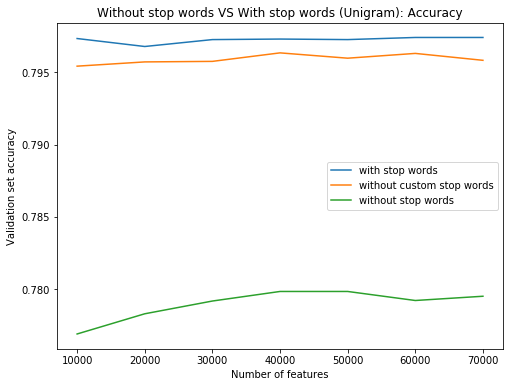

In [33]:
plt.figure(figsize=(8,6))
plt.plot(n_features, feature_result_with_stop, label='with stop words')
plt.plot(n_features, feature_result_custom_stop,label='without custom stop words')
plt.plot(n_features, feature_result_without_stop,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### N Grams

In [34]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.08%
accuracy score: 81.08%
model is 30.99% more accurate than null accuracy
train and test time: 10.38s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.08%
accuracy score: 81.69%
model is 31.60% more accurate than null accuracy
train and test time: 10.48s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.08%
accuracy score: 81.77%
model is 31.69% more accurate than null accuracy
train and test time: 11.90s
-----------------------------------------------------------

In [37]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.08%
accuracy score: 81.08%
model is 30.99% more accurate than null accuracy
train and test time: 19.84s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.08%
accuracy score: 81.52%
model is 31.44% more accurate than null accuracy
train and test time: 19.61s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.08%
accuracy score: 81.78%
model is 31.70% more accurate than null accuracy
train and test time: 19.56s
----------------------------------------------------------

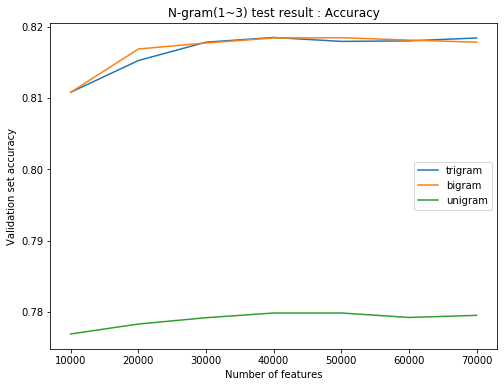

In [38]:
plt.figure(figsize=(8,6))
plt.plot(n_features, feature_result_tg,label='trigram')
plt.plot(n_features, feature_result_bg,label='bigram')
plt.plot(n_features, feature_result_without_stop, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [39]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    """Helper function to train and validate some model"""
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print( confusion)
    print ("-"*80)
    print( "Classification Report\n")
    print( classification_report(y_test, y_pred, target_names=['negative','positive']))

In [41]:
# test our best performing model
%%time
vectorizer = CountVectorizer(max_features=70000,ngram_range=(1, 3))
tfidf_transformer = TfidfTransformer()
classifier = LogisticRegression()

bg_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', tfidf_transformer),
            ('classifier', classifier)
        ])
    
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

UsageError: Line magic function `%%time` not found.


## Test submission

In [42]:
with open('data/test_data.txt',"r") as file:
    df_unknown = file.read().split('\n')
df_unknown = pd.DataFrame({'tweet' : df_unknown})[:len(df_unknown)-1]
df_unknown.index += 1 
df_unknown['tweet'] = df_unknown['tweet'].apply(lambda x : str(x).split(',', maxsplit=1)[1])
df_unknown

,tweet
1,sea doo pro sea scooter ( sports with the port...
2,<user> shucks well i work all week so now i ca...
3,i cant stay away from bug thats my baby
4,<user> no ma'am ! ! ! lol im perfectly fine an...
5,"whenever i fall asleep watching the tv , i alw..."
...,...
9996,had a nice time w / my friend lastnite
9997,<user> no it's not ! please stop !
9998,not without my daughter ( dvd two-time oscar (...
9999,<user> have fun in class sweetcheeks


In [43]:
df_unknown['tweet'] = df_unknown['tweet'].apply(tweet_cleaner)

In [44]:
vectorizer = CountVectorizer(max_features=70000,ngram_range=(1, 3))
tfidf_transformer = TfidfTransformer()

vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

clf = LogisticRegression().fit(x_train_tfidf, y_train)

X_to_predict = df_unknown['tweet']
X_to_predict = vectorizer.transform(X_to_predict)
X_to_predict = tfidf_transformer.transform(X_to_predict)

df_unknown = clf.predict(X_to_predict)
df_unknown[df_unknown == 0] = -1 #replace 0 to -1

In [45]:
create_csv_submission([x for x in range(1,len(df_unknown)+1)],df_unknown,"output_z2.csv")